# ReAct Agent with RAG - Tutorial 2

In this tutorial, we are going to create a simple **ReAct agent** with LangGraph and capable of performing **Information Retrieval (RAG)** from external data sources.

The graph architecture is the same of the [Simple ReAct Agent](https://github.com/Marianna-Pinho/llm_studies_2024/blob/main/src/introduction/simple_react_agent_with_memory.py):

![Simple ReAct Agent with RAG](https://github.com/Marianna-Pinho/llm_studies_2024/blob/main/figures/simple_graph_with_memory.png)

- The **Chat Node** receives a question and it is responsible to decide to answer to the question or to search for relevant information in external sources.
- The **Tool Node** is responsible for retriving the relevant information according to the question (tool parameters) and for returning it back to the chat node, which will then use it to answer the question. 

### Setting up

In [1]:
## This loads the environment variables defined in a .env file. 
# It's useful to load secrets
import dotenv
dotenv.load_dotenv()

True

### Creating the RAG retriever components

More on RAGs can be found on [Retrieval Augmented Generation - Tutorial 1](https://github.com/Marianna-Pinho/llm_studies_2024/blob/main/notebooks/langchain/tutorial_01_simple_rag_unstructured_data.ipynb). 

In [2]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

In [3]:
## Load the documents

path_pdfs = "notebooks/langchain/data/pdf"
pdf_loader = PyPDFDirectoryLoader(path=path_pdfs)

pdf_documents = pdf_loader.load()

print("Number of documents (sum of the number of pages of all PDFs):", len(pdf_documents))
print("Types of infos:", pdf_documents[0].__dict__.keys())

Number of documents (sum of the number of pages of all PDFs): 125
Types of infos: dict_keys(['id', 'metadata', 'page_content', 'type'])


In [4]:
## Split the documents into smaller chunks

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

pdf_text_splits = text_splitter.split_documents(pdf_documents)

print("Number of generated chunks (smaller documents):", len(pdf_text_splits))
print("Types of infos:", pdf_text_splits[0].__dict__.keys())

Number of generated chunks (smaller documents): 924
Types of infos: dict_keys(['id', 'metadata', 'page_content', 'type'])


In [5]:
# Generates an string ID that is the combination of a chunk metadata
def generate_id(index, chunk):
    source = chunk.metadata["source"]
    page = chunk.metadata["page"]

    return f"idx_{index}_page_{page}_source_{source}"


# Creates the embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-l6-v2")
# Creates the vector store and stores the chunks generated before
# To prevent the vector store to store repeated data, we will create unique ids that uses chunks metadata
# So, the same chunk will always generate the same id
ids = [generate_id(index=idx, chunk=chunk) for idx, chunk in enumerate(pdf_text_splits)]

## Creates the Vector Store
vector_store = Chroma.from_documents(
    collection_name="alzheimer_papers_rag_tutorial_01",
    persist_directory="./notebooks/data/chroma",
    embedding=embedding_model,
    documents=pdf_text_splits,
    ids=ids
)

vs_info = vector_store.get(include=["embeddings", "documents", "metadatas"])
for key in vs_info:
    print(f"{key}: {len(vs_info[key])}" if isinstance(vs_info[key], list) else f"{key}: {vs_info[key]}", end=" | ")

/home/mariannadepinhosevero/Documentos/petro/studies/langgraph/langchain-academy/lc-academy-env/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/home/mariannadepinhosevero/Documentos/petro/studies/langgraph/langchain-academy/lc-academy-env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


ids: 924 | embeddings: 924 | metadatas: 924 | documents: 924 | uris: None | data: None | included: 3 | 

In [6]:
# We create a retriever that uses similarity search and returns the 20 most similar to the query documents/chunks
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs = {"k": 20}
)

### Create the Graph

More on creating Agents with LangGraph on [llm_studies_2024](https://github.com/Marianna-Pinho/llm_studies_2024/tree/main/src). 

In [16]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START

#### 1. Define the Graph State

In [9]:
class ChatRagState(TypedDict):
    # The chat messages
    messages: Annotated[list[AnyMessage], add_messages]

#### 2. Define the nodes

In this example, we will represent the **Retriever** as a **Tool** and we will embed its execution in a tool node.



In [10]:
def format_retrieved_docs(documents):
    return "\n\n".join([doc.page_content for doc in documents])

def retriever_tool(question:str) -> str:
    """
    Receives a question and searches in a vector store for contexts that are relevant to the question.

    Args:
        question: the query to be used in the vector store search.
    """
    context = format_retrieved_docs(retriever.invoke(input=question))

    return context


chat_tools = [retriever_tool]

In [26]:
chat_model = ChatOpenAI(model="gpt-3.5-turbo").bind_tools(chat_tools)

def chat_node(state: ChatRagState):
    prompt = ("You are a helpful assistant for question-answering tasks and an expert in Alzheimers cientific research."
              " Answer the user questions based on you knowledge and previous interations. If you don't know the answer, don't make up it."
              " Instead, search in a vector store for relevant information about the question and use it to answer.")

    prompt_alternative = ("You are a helpful assistant for question-answering tasks and an expert in Alzheimers cientific research."
              " Answer the user questions using exclusively the knowledge retrieved from a vector store with relevant information about the question." 
              "If you don't know the answer, don't make up it.")
    
    system_message = SystemMessage(content=prompt_alternative)

    return {"messages": chat_model.invoke(input=[system_message] + state["messages"])}

#### 3. Create the graph

Here, we skipped the creation of conditional edges before, because we will define them in this step using `tools_condition`. In other scenarios, we would have a previous step for defining the conditional edges.

In [27]:
def create_graph():
    # Instantiates the graph with the defined Graph State
    graph = StateGraph(ChatRagState)

    # Define the nodes
    graph.add_node("chat node", chat_node)
    graph.add_node("tools", ToolNode(tools=chat_tools))

    # Define the edges
    graph.add_edge(START, "chat node")
    graph.add_conditional_edges(
        source="chat node",
        path=tools_condition
    )
    graph.add_edge("tools", "chat node")

    graph = graph.compile()
    
    return graph

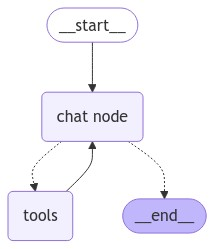

In [28]:
from IPython.display import display, Image

graph = create_graph()

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
question = HumanMessage(content="O Alzheimer é comum em que segmentos da população?", name="user")
messages = {"messages": [question]}

response = graph.invoke(input=messages)

for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================
Name: user

O Alzheimer é comum em que segmentos da população?
================================== Ai Message ==================================
Tool Calls:
  retriever_tool (call_RazGFMeHtaQy5IhF4A9rvaHw)
 Call ID: call_RazGFMeHtaQy5IhF4A9rvaHw
  Args:
    question: Alzheimer common population segments
================================= Tool Message =================================
Name: retriever_tool

Association’s 2010 Alzheimer’s Disease Facts and Figures .
A9.Projected number ofpeople with Alzheimer’s dementia: This
figure comes from the CHAP study.62Other projections are
 15525279, 2020, 3, Downloaded from https://alz-journals.onlinelibrary.wiley.com/doi/10.1002/alz.12068 by CAPES, Wiley Online Library on [25/09/2024]. See the Terms and Conditions (https://onlinelibrary.wiley.com/terms-and-conditions) on Wiley Online Library for rules of use; OA articles are governed by the applicable Creative Common

### Chatting with the graph

In [20]:
import time
from langgraph.checkpoint.memory import MemorySaver

#### Without Memory

In [30]:
chat_graph = create_graph()

ser_input = ""

while True:
    user_input = input("Typing: ")

    if user_input == "END":
        break
    
    user_input = HumanMessage(content=user_input, name="User")
    response = chat_graph.invoke(input={"messages": user_input})

    time.sleep(3)

    for msg in response["messages"]:
        msg.pretty_print()
    print("***"*35)

================================ Human Message =================================
Name: User

Oi, tudo bem?
================================== Ai Message ==================================

Olá! Estou aqui para ajudar. Em que posso ser útil hoje?
*********************************************************************************************************
================================ Human Message =================================
Name: User

O que é o Alzheimer?
================================== Ai Message ==================================
Tool Calls:
  retriever_tool (call_0iXQcdRKWGfhwfHxvwZdEnl7)
 Call ID: call_0iXQcdRKWGfhwfHxvwZdEnl7
  Args:
    question: O que é o Alzheimer?
================================= Tool Message =================================
Name: retriever_tool

University Press; 2007. p. 193–228 .C.R. Jack Jr. et al. / Alzheimer’ s & Dementia 14 (2018) 535-562 556
 15525279, 2018, 4, Downloaded from https://alz-journals.onlinelibrary.wiley.com/doi/10.1016/j.jalz.2

#### With Memory

In order to add memory to our graph, we need to **compile it with a checkpointer**. This checkpointer can be any database, such as SQLite, MongoDB or other. However, in this example, we are going to save the **Graph State** in memory with the `Memory Saver` checkpointer.

In [31]:
def create_graph_with_memory(checkpointer):
    # Instantiates the graph with the defined Graph State
    graph = StateGraph(ChatRagState)

    # Define the nodes
    graph.add_node("chat node", chat_node)
    graph.add_node("tools", ToolNode(tools=chat_tools))

    # Define the edges
    graph.add_edge(START, "chat node")
    graph.add_conditional_edges(
        source="chat node",
        path=tools_condition
    )
    graph.add_edge("tools", "chat node")

    graph = graph.compile(checkpointer=checkpointer)
    
    return graph

In [32]:
memory_checkpointer = MemorySaver()
chat_graph = create_graph_with_memory(checkpointer=memory_checkpointer)
config = {"configurable": {"thread_id": "1"}}

ser_input = ""

while True:
    user_input = input("Typing: ")

    if user_input == "END":
        break
    
    user_input = HumanMessage(content=user_input, name="User")
    response = chat_graph.invoke(input={"messages": user_input}, config=config)

    time.sleep(3)

    for msg in response["messages"]:
        msg.pretty_print()
    print("***"*35)

================================ Human Message =================================
Name: User

O Alzheimer é mais comum em homens ou em mulheres?
================================== Ai Message ==================================
Tool Calls:
  retriever_tool (call_x30q2N5gxf1ZL1ObymzRyEga)
 Call ID: call_x30q2N5gxf1ZL1ObymzRyEga
  Args:
    question: Alzheimer prevalence in men and women
================================= Tool Message =================================
Name: retriever_tool

Alzheimer’s or other dementias compared with 11% of men.187
The prevailing reason that has been stated for the higher preva-
lence of Alzheimer’s and other dementias in women is that women
live longer than men on average, and older age is the greatest risk
factor for Alzheimer’s.211-213But when it comes to differences in the
actual risk of developing Alzheimer’s or other dementias for men and
women of the same age, findings have been mixed. Most studies of
incidence in the United States have found no signi